In [35]:
import os
import joblib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [36]:
DATA_PATH = os.path.join(os.getcwd(), '..', 'dataset', 'Churn_Modelling.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [37]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [38]:
# Drop first 3 features
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Split to train & test

In [39]:
# to featueres & target 
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45, stratify=y)


In [40]:
# Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (8000, 10)
y_train.shape 	 (8000,)
******************************
X_test.shape 	 (2000, 10)
y_test.shape 	 (2000,)


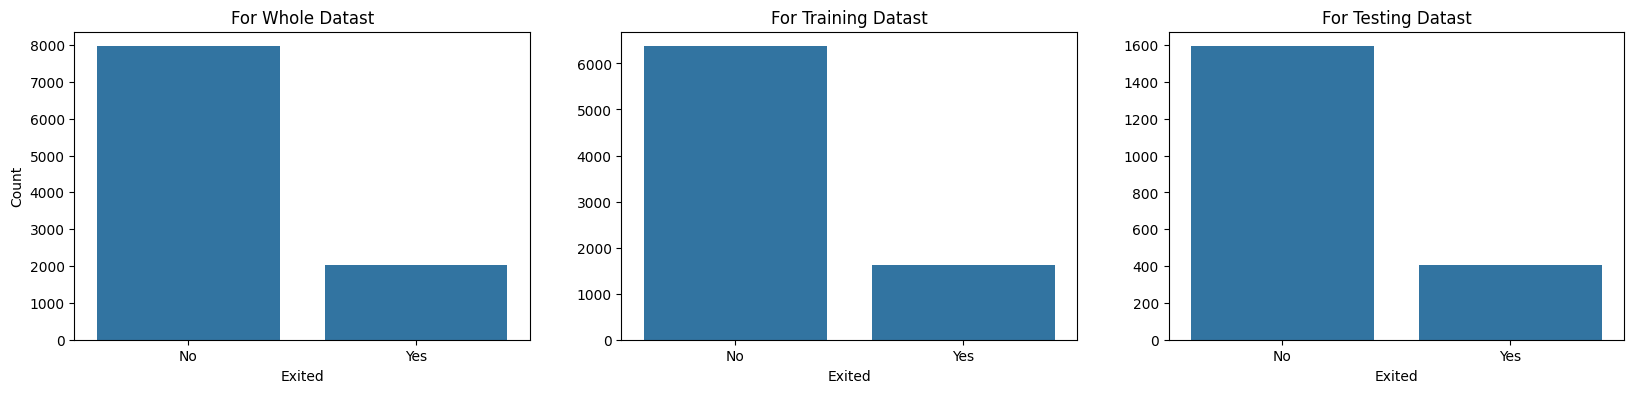

In [41]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Feature Selection & Preporcessing

In [42]:
# slice cols
num_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categ_cols = ['Gender', 'Geography']
ready_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(categ_cols))

In [43]:
# Numerical cols (num_cols) & Target cols --> ANOVA
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
p_val   # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([4.53937410e-151, 9.93415956e-002, 4.93061528e-027, 3.77885631e-001])

In [44]:
# Categorical cols (categ_cols) & Target cols --> chi2
_, p_val = chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]), y=y_train)
p_val  # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([2.10648846e-11, 1.19256538e-03])

In [45]:
# Ready cols (ready_cols) & Target cols --> chi2
_, p_val = chi2(X=X_train[ready_cols], y=y_train)
p_val  # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([1.37949728e-01, 6.52077590e-02, 9.69193084e-01, 2.05442478e-21])

In [46]:
# Pipeline

# Numerical: num_cols --> Imputing using median, and standardscaler
# Categorical: categ_cols ---> Imputing using mode, and OHE
# Ready_cols ---> Imputing mode


# For Numerical
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For Categorical
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))
])

# For Ready cols
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# Combine all
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_cols),
    ('categorical', categ_pipeline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

# Apply to train and test
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [47]:
# Check train
X_train_final.shape, y_train.shape

((8000, 11), (8000,))

In [48]:
# Check test
X_test_final.shape, y_test.shape

((2000, 11), (2000,))

# Deal with imbalanced dataset

In [49]:
# 2. Using SMOTE for over sampling
over = SMOTE(k_neighbors=5, sampling_strategy=0.7, random_state=45)
X_train_final_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train)

In [50]:
# Create fodler for the models
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'models')
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)

In [51]:
# dump the preprocessor
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, 'preprocessor.pkl'))

['c:\\Users\\KARIM\\Downloads\\Churn-Modelling\\notebook\\..\\models\\preprocessor.pkl']

# Building Models

## logistic regression 

In [52]:
# 1. Using logisit -- without considering the imabalancing data
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)


print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 32.437
The f1_score using Logistic model for Testing Dataset is 30.631


In [53]:
log_clf = LogisticRegression(class_weight='balanced')
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)


print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 50.077
The f1_score using Logistic model for Testing Dataset is 48.213


In [54]:
# 3. Using logisit -- with considering the imabalancing data using oversampled data (SMOTE)
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Using f1_score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset with SMOTE is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset with SMOTE is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset with SMOTE is 49.537
The f1_score using Logistic model for Testing Dataset with SMOTE is 49.064


<Axes: >

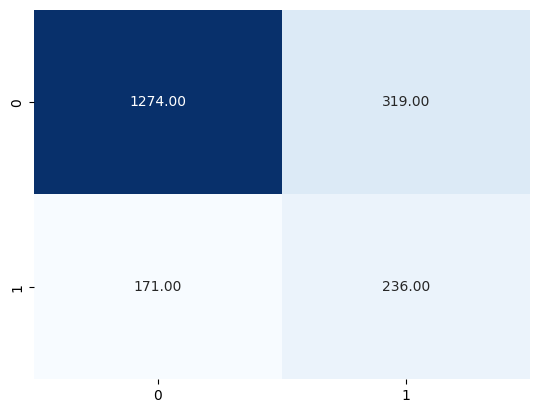

In [55]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_test_log), cmap='Blues', cbar=False, annot=True, fmt='.2f')

In [56]:
# clf report
print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1593
           1       0.43      0.58      0.49       407

    accuracy                           0.76      2000
   macro avg       0.65      0.69      0.66      2000
weighted avg       0.79      0.76      0.77      2000



# RandomForest

In [57]:
# Using RF -- With class_weights
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight='balanced')
forst_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_foerst = forst_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with class_weights is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with class_weights is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with class_weights is 60.957
The f1_score using RF model for Testing Dataset with class_weights is 58.740


In [58]:
# Using RF -- With SMOTE
forst_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forst_clf.fit(X_train_final_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_forest = forst_clf.predict(X_train_final)
y_pred_test_foerst = forst_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with SMOTE is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with SMOTE is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with SMOTE is 62.228
The f1_score using RF model for Testing Dataset with SMOTE is 57.143


In [59]:
forest_base_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight='balanced')

# Your space to search
params_best_grid = {
            'n_estimators': np.arange(50, 400, 50),
            'max_depth': np.arange(6, 10, 2)
}

grid_search_forest = GridSearchCV(estimator=forest_base_clf, param_grid=params_best_grid, 
                                  cv=5, n_jobs=1, verbose=4, scoring='f1')

grid_search_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ......max_depth=6, n_estimators=50;, score=0.629 total time=   0.2s
[CV 2/5] END ......max_depth=6, n_estimators=50;, score=0.584 total time=   0.2s
[CV 3/5] END ......max_depth=6, n_estimators=50;, score=0.601 total time=   0.2s
[CV 4/5] END ......max_depth=6, n_estimators=50;, score=0.611 total time=   0.2s
[CV 5/5] END ......max_depth=6, n_estimators=50;, score=0.565 total time=   0.2s
[CV 1/5] END .....max_depth=6, n_estimators=100;, score=0.630 total time=   0.4s
[CV 2/5] END .....max_depth=6, n_estimators=100;, score=0.580 total time=   0.4s
[CV 3/5] END .....max_depth=6, n_estimators=100;, score=0.603 total time=   0.4s
[CV 4/5] END .....max_depth=6, n_estimators=100;, score=0.617 total time=   0.5s
[CV 5/5] END .....max_depth=6, n_estimators=100;, score=0.567 total time=   0.5s
[CV 1/5] END .....max_depth=6, n_estimators=150;, score=0.644 total time=   0.8s
[CV 2/5] END .....max_depth=6, n_estimators=150;

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=5, n_estimators=150,
                                              random_state=45),
             n_jobs=1,
             param_grid={'max_depth': array([6, 8]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='f1', verbose=4)

In [60]:
# The best score according to your scoring & The best combination of what you search in
grid_search_forest.best_score_, grid_search_forest.best_params_

(0.6176898045354173, {'max_depth': 8, 'n_estimators': 50})

In [61]:
# The forest after tuning
forest_tuned = grid_search_forest.best_estimator_

# Predict and evaluate
y_pred_train_forest_tuned = forest_tuned.predict(X_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(X_test_final)

# Using f1_scorea
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f'The f1_score using tuned RF model for Training Dataset with class_weigths is {score_train_forest_tuned*100:.3f}')
print(f'The f1_score using tuned RF model for Testing Dataset with class_weigths is {score_test_forest_tuned*100:.3f}')

The f1_score using tuned RF model for Training Dataset with class_weigths is 68.962
The f1_score using tuned RF model for Testing Dataset with class_weigths is 59.542


In [62]:
# Downlaod it if you are satisifed with the above model
joblib.dump(forest_tuned, os.path.join(MODELS_FOLDER_PATH, 'forest_tuned.pkl'))

['c:\\Users\\KARIM\\Downloads\\Churn-Modelling\\notebook\\..\\models\\forest_tuned.pkl']

In [63]:
# Get the features out from the preprocessor
features_after = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
features_after

['Age',
 'CreditScore',
 'Balance',
 'EstimatedSalary',
 'Gender_Male',
 'Geography_Germany',
 'Geography_Spain',
 'NumOfProducts',
 'Tenure',
 'HasCrCard',
 'IsActiveMember']

In [64]:
# Feature Importance from RF
forest_tuned_importance = pd.DataFrame({'feature': features_after, 
                              'importance': forest_tuned.feature_importances_}).sort_values('importance', ascending=False)
forest_tuned_importance

,feature,importance
0,Age,0.384143
7,NumOfProducts,0.238632
2,Balance,0.088393
10,IsActiveMember,0.065250
5,Geography_Germany,0.053312
3,EstimatedSalary,0.050163
1,CreditScore,0.049542
4,Gender_Male,0.028793
8,Tenure,0.028659
6,Geography_Spain,0.006722


# XGBoost

In [65]:
xgb_base_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, 
                                 learning_rate=0.1, n_estimators=150, random_state=42)
xgb_base_model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_xgb = xgb_base_model.predict(X_train_final)
y_pred_test_xgb = xgb_base_model.predict(X_test_final)

# Using f1_score
score_train_xgb = f1_score(y_train, y_pred_train_xgb)
score_test_xgb = f1_score(y_test, y_pred_test_xgb)

print(f'The f1_score using XGBoost model for Training Dataset with scale is {score_train_xgb*100:.3f}')
print(f'The f1_score using XGBoost model for Testing Dataset with scale is {score_test_xgb*100:.3f}')

The f1_score using XGBoost model for Training Dataset with scale is 69.259
The f1_score using XGBoost model for Testing Dataset with scale is 59.403


In [70]:
# Dump model
joblib.dump(xgb_base_model, os.path.join(MODELS_FOLDER_PATH, 'xgb_base_model.pkl'))

['c:\\Users\\KARIM\\Downloads\\Churn-Modelling\\notebook\\..\\models\\xgb_base_model.pkl']